In [1]:
import pyfesom2 as pf
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import cmocean.cm as cmo

osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


# Transports in pyfesom2
This is the example notebook for computing cross-section transports from FESOM2 data.
Transport across meridional and zonal sections can be computed with the cross_section_transport.py function. Sections that are neither zonal or meridional are not yet supportedThe velocity data is needed on elements (e.g. u.fesom.2000.nc, v.fesom.2000.nc).  
The computation is performed according to: Simple algorithms to compute meridional overturning and barotropic streamfunctions on unstructured meshes (Sidorenko et al., 2020)

### Let's compute the transport across the Barents Sea Opening...

In [36]:
transport, section = pf.cross_section_transport('BSO',                                                          # select a section from the presets or [lon1, lon2, lat1, lat2]
                                                mesh_path='/home/ollie/fheukamp/mesh/Arc01_fesom2/',            # directory of the mesh files
                                                data_path='/work/ollie/fheukamp/result/Arc01_JRA55/cycle_2/',   # directory of the u, v, (T, S, uice, vice, m_ice, a_ice) files
                                                mesh_diag_path=None,                                            # absolute path to the mesh_diag_file or None if the same as mesh_path
                                                years=np.arange(1995,2005),                                     # years to compute
                                                use_great_circle=False,                                  # compute the section as a great circle
                                                how='ori',                                               # 'ori' do not apply mean, 'mean' apply time mean
                                                add_TS=True,                                            # add temperature and salinity to the section
                                                add_extent=1                                             # the extent to look for gridcells nerby the section, choose large for low resolutions
                                               )

/home/ollie/fheukamp/mesh/Arc01_fesom2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /home/ollie/fheukamp/mesh/Arc01_fesom2/pickle_mesh_py3_fesom2
The section starts and ends in the ocean. Those elements that contain the start and end coordinate of the section are droped.
[########################################] | 100% Completed | 39.8s
[########################################] | 100% Completed | 34.2s


### Take a look at the output...
Two outputs are returned by the function: an xr.Dataset containing the transport data and a dictionary containing informations on the section

#### The section dictionary contains information about the section: 
- start and end coordinates
- name of the section in case a preset is used
- orientation of the section
- whether a great circle was used or not
- the years that were computed
- the edge midpoints and element centers for each gridpoints that form the broken line across which the transport is computed

#### The transport xr.Dataset containing the actual transport and additional data...

In [25]:
print(transport)

<xarray.Dataset>
Dimensions:                (elem: 199, nz1: 45, time: 72, triple: 3)
Coordinates:
  * nz1                    (nz1) float64 5.0 15.0 25.0 ... 5.525e+03 5.775e+03
  * time                   (time) datetime64[ns] 1995-01-31T23:55:00 ... 2000...
Dimensions without coordinates: elem, triple
Data variables:
    elem_indices           (elem) int64 946680 946681 946683 ... 1070060 1070523
    elem_nods              (elem, triple) int64 481696 481761 ... 544153 544155
    zonal_distance         (elem) float64 -2.129e+03 431.3 ... -206.2 -571.7
    meridional_distance    (elem) float64 1.628e+03 2.669e+03 ... 2.425e+03
    vertical_cell_area_dx  (elem, nz1) float64 -2.129e+04 ... -1.429e+05
    vertical_cell_area_dy  (elem, nz1) float64 1.628e+04 1.628e+04 ... 6.062e+05
    lon_center             (elem) float64 20.04 20.07 20.02 ... 19.99 19.94
    lat_center             (elem) float64 70.13 70.16 70.18 ... 74.47 74.49
    u                      (time, elem, nz1) float64 0.01492

## Plot the results...


### First, define some plotting functions...

In [26]:
def PlotBackground(ax, section, closeup=False):
    
    ''''''
    gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color="gray",
    alpha=0.5,
    linestyle="--",
    x_inline=True,
    y_inline=False,
    zorder=20,
    )
    
    if closeup:
        ax.set_extent([19.8,20.1,73.25,73.75], crs=ccrs.PlateCarree())
    
        gl.xlocator = mticker.FixedLocator(
            [_ for _ in np.arange(19.8,20.05,.05)],
        )
        gl.ylocator = mticker.FixedLocator(np.arange(73.25,73.8,.05))
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    
    else:
        if section['name'] == 'BSO':
            ax.set_extent([18, 21, 69, 75], crs=ccrs.PlateCarree())

            gl.xlocator = mticker.FixedLocator(
                [_ for _ in np.arange(15,26,1)],
            )
            gl.ylocator = mticker.FixedLocator(np.arange(70,76,1))
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER

        elif section['name'] == 'BSX':
            ax.set_extent([62, 66, 74, 82], crs=ccrs.PlateCarree())

            gl.xlocator = mticker.FixedLocator(
                [_ for _ in np.arange(62,65,1)],
            )
            gl.ylocator = mticker.FixedLocator(np.arange(60,85,1))
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER

    ax.add_feature(cfeature.LAND, zorder=10, color='grey')

    gl.xlabel_style = {"size": 12, "rotation": 0}
    gl.ylabel_style = {"size": 12, "rotation": 0}
    
    

    return



def FindColorLevels(z, pcolor=True, div=True):
    '''
    '''
    min_lev = np.nanmin(z.flatten())
    max_lev = np.nanmax(z.flatten())
    
    if div:
        if np.abs(min_lev) > max_lev:
            if pcolor:
                levels=[-min_lev, min_lev]
            else:
                levels = np.arange(-min_lev, min_lev+min_lev/10, min_lev/10)

        elif np.abs(min_lev) < max_lev:
            if pcolor:
                levels=[-max_lev, max_lev]
            else:
                levels = np.arange(-max_lev, max_lev+max_lev/10, max_lev/10)
                
    else:
        levels = [min_lev, max_lev]
        
    return levels


def PlotSectionBirdview(transport, section, mesh):
    '''
    Plot the section from above
    '''
    
    # Set up figure 
    fig, ax = plt.subplots(1,1, figsize=(10,15), subplot_kw=dict(projection=ccrs.PlateCarree()))
    PlotBackground(ax, section)

    cb = ax.tripcolor(mesh.x2, mesh.y2, transport.elem_nods.values,transport.u.mean(dim=('time','nz1')), transform=ccrs.PlateCarree(), cmap='inferno', edgecolor='chartreuse')
    
    if section['orientation'] == 'meridional':
        ax.plot([section['lon_start'], section['lon_end']],[section['lat_start'], section['lat_end']], 'r-', transform=ccrs.PlateCarree())
    
    cbar = plt.colorbar(cb, ax=ax)
    cbar.set_label('depth averaged zonal velocity', fontsize=12)
    plt.show()
    return


def PlotDepthSection(transport, section, cmap='RdBu_r', unit='m/s', div=True, levels=None, ylim=(500,0)):
    '''
    Plot the depth section of the velocity on the original grid
    '''
    
    fig, ax = plt.subplots(1,1, figsize=(15,10))
    
    
    
    if section['orientation'] == 'meridional':
        if levels==None:
            levels = FindColorLevels(transport.u.mean(dim='time').values, pcolor=False, div=div)
            
        cb = ax.contourf(transport.lat_center, 
                    transport.nz1, 
                    transport.u.mean(dim='time').where(transport.u.mean(dim='time') != 0, np.nan).transpose(),
                    cmap=cmap, 
                    levels=levels
                   )
        
        cbar = plt.colorbar(cb,ax=ax, orientation='horizontal', shrink=.7)
        cbar.set_label('u ' + 'in ' + unit, fontsize=12)
        cbar.ax.tick_params(labelsize=12)
        ax.invert_yaxis()
        ax.set_ylim(ylim)
        ax.set_xlabel('latitude', fontsize=12)
        ax.set_ylabel('depth', fontsize=12)
        ax.tick_params(labelsize=12)
   
    if section['orientation'] == 'zonal':
        if levels==None:
            levels = FindColorLevels(transport.v.mean(dim='time').values, pcolor=False, div=div)
            
        cb = ax.contourf(transport.lon_center, 
                    transport.nz1, 
                    transport.v.mean(dim='time').where(transport.v.mean(dim='time') != 0, np.nan).transpose(),
                    cmap=cmap, 
                    levels=levels
                   )
        
        cbar = plt.colorbar(cb,ax=ax, orientation='horizontal', shrink=.7)
        cbar.set_label('v ' + 'in ' + unit, fontsize=12)
        cbar.ax.tick_params(labelsize=12)
        ax.invert_yaxis()
        ax.set_ylim(ylim)
        ax.set_xlabel('latitude', fontsize=12)
        ax.set_ylabel('depth', fontsize=12)
        ax.tick_params(labelsize=12)

    return 

### Second, we need to load the mesh file and mesh_diag file

In [27]:
mesh = pf.load_mesh('/home/ollie/fheukamp/mesh/Arc01_fesom2/')
mesh_diag = xr.open_dataset('/home/ollie/fheukamp/mesh/Arc01_fesom2/fesom.mesh.diag.nc')

/home/ollie/fheukamp/mesh/Arc01_fesom2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /home/ollie/fheukamp/mesh/Arc01_fesom2/pickle_mesh_py3_fesom2


### Let's take a look at the section from a birds perspective...

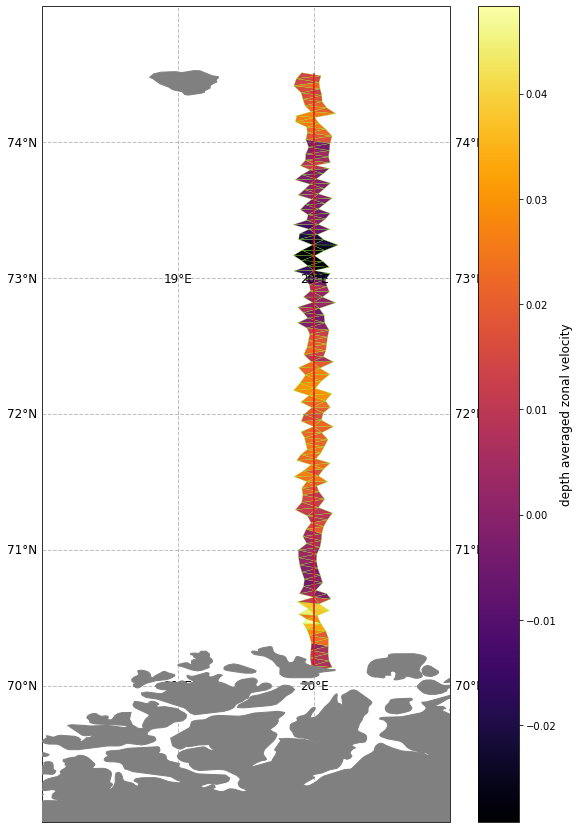

In [28]:
PlotSectionBirdview(transport, section, mesh)

### Look at a closeup of the section
The transport is computed across the red line, consisting of two line segments for each intersected mesh element that form the edge of the control volumes. Each elements two lines are expresed as vectors in local cartesian coordinates with repsect to their element to compute the transports across.

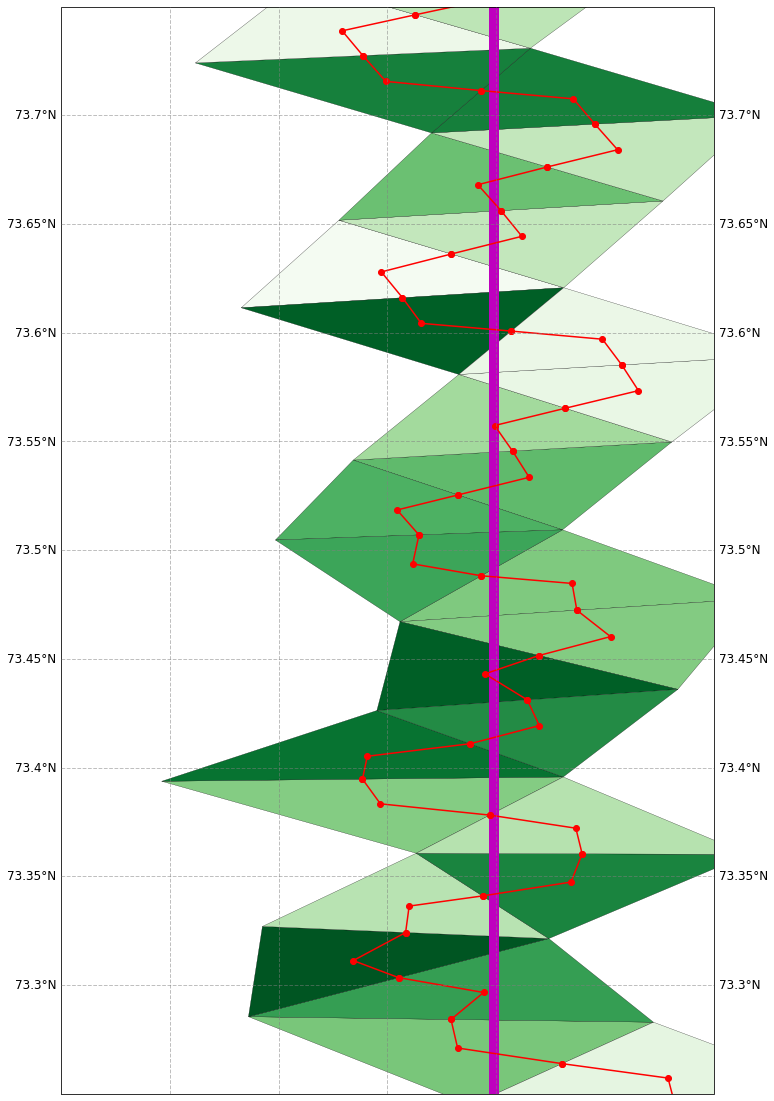

In [29]:
fig, ax = plt.subplots(1,1, figsize=(20,20), subplot_kw=dict(projection=ccrs.PlateCarree()))
PlotBackground(ax, section, closeup=True)

# Plot the mesh elements
ax.tripcolor(mesh.x2, mesh.y2, transport.elem_nods, np.random.rand(len(transport.elem_indices)), transform=ccrs.PlateCarree(), edgecolor='k', cmap='Greens')
# Plot the linear section
ax.plot([section['lon_start'],section['lon_end']],[section['lat_start'],section['lat_end']], 'm-', linewidth=10, transform=ccrs.PlateCarree())
# Plot the actual section
for i in range(len(section['f_lon'])):
    ax.plot([section['f_lon'][i],section['c_lon'][i],section['s_lon'][i]], [section['f_lat'][i],section['c_lat'][i],section['s_lat'][i]],'r-o', transform=ccrs.PlateCarree())
    

### We can plot data of the depth-section


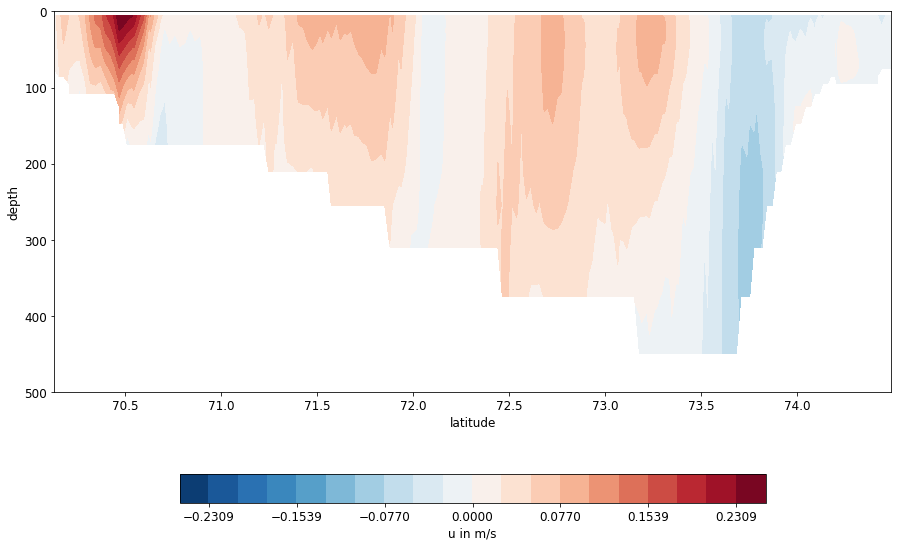

In [30]:
PlotDepthSection(transport, section, unit='m/s', cmap='RdBu_r')

### Now we compute the net transport across the section as a timeseries...
We make use of xarrays build in sum() functions to compute the transport across the section. To get the transport we sum up the single cell transports stored in transport.transport_across over the horizontal and vertical dimensions ('elem','nz1') and converting m3/s to Sverdrups

In [37]:
net_transport = transport.transport_across.sum(dim=('elem','nz1')) * 1e-6

We recieve an xarray.DataArray containing the transport that we can easily plot with xarrays build in plotting routines:

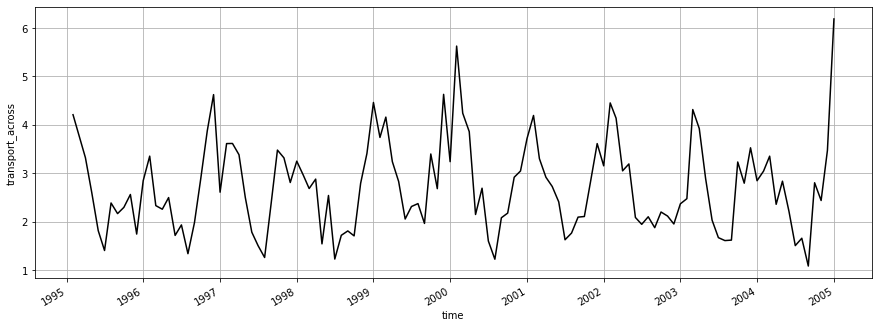

In [38]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.grid(':')

net_transport.plot(ax=ax, color='k')

### Add temperature/ salinity criteria to the transport...

Furthermore, it's easy to apply a temperature and/or salinity condition to compute only transports in specific TS ranges. For this we use the xarray.DataArray.where() function.   
Let's compute the warm/cold water transport, with water warmer/colder than 6°C. We set the transport in cells where the temperature is below/above 6°C to 0, so they do not contribute when we sum them up to recieve the total transport.

In [40]:
warm_water_transport = transport.transport_across.where(transport.temp > 6, 0).sum(dim=('elem','nz1')) * 1e-6
cold_water_transport = transport.transport_across.where(transport.temp <= 6, 0).sum(dim=('elem','nz1')) * 1e-6

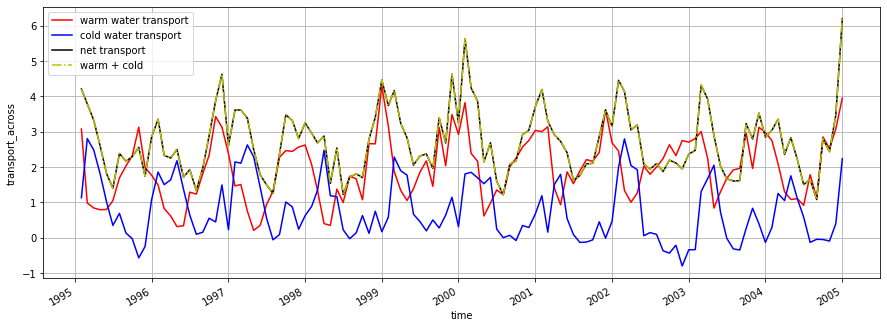

In [41]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.grid(':')

warm_water_transport.plot(ax=ax, color='r', label='warm water transport')
cold_water_transport.plot(ax=ax, color='b', label='cold water transport')
net_transport.plot(ax=ax, color='k', label='net transport')
(warm_water_transport + cold_water_transport).plot(ax=ax, color='y', linestyle='-.', label='warm + cold')

plt.legend()
plt.show()